<a href="https://colab.research.google.com/github/d0lev/API-Security-Detection/blob/main/challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cisco - Ariel University API Security Detection Challenge 2023
### Imports and global settings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Imports, settings and first dataset view
import pandas as pd
import seaborn as sns
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [550]:
# Set pandas to show all columns when you print a dataframe
pd.set_option('display.max_columns', None)

# Global setting here you choose the dataset number and classification type for the model
dataset_path = "/content/drive/MyDrive/CiscoChallenge/Data/dataset_1_train.json";
test_type = 'label' # Options are ['label', 'attack_type']

# Read the json and read it to a pandas dataframe object, you can change these settings
with open(dataset_path) as file:
    raw_ds = json.load(file)
df = pd.json_normalize(raw_ds, max_level=2)

# **Preprocessing**

---
> At this step we will engineer the various features in the data set,  It involves transforming data to forms that better relate to the underlying target to be learned. 

> In the data set, there are various attacks on the API, for this purpose, we will create a binary column that will describe whether or not any attack was carried out in each record

In [551]:
# Fill the black attack tag lines with "Benign" string
df['request.Attack_Tag'] = df['request.Attack_Tag'].fillna('Benign')
df['attack_type'] = df['request.Attack_Tag']

# Any entry that contains a particular attack will be labeled malware.
def categorize(row):  
    if row['request.Attack_Tag'] == 'Benign': 
        return 'Benign'
    return 'Malware'

df['label'] = df.apply(lambda row: categorize(row), axis=1)

# After finishing the arrangements we delete the irrelevant column
df.drop('request.Attack_Tag', axis=1, inplace=True)

### **Classes distribution :**

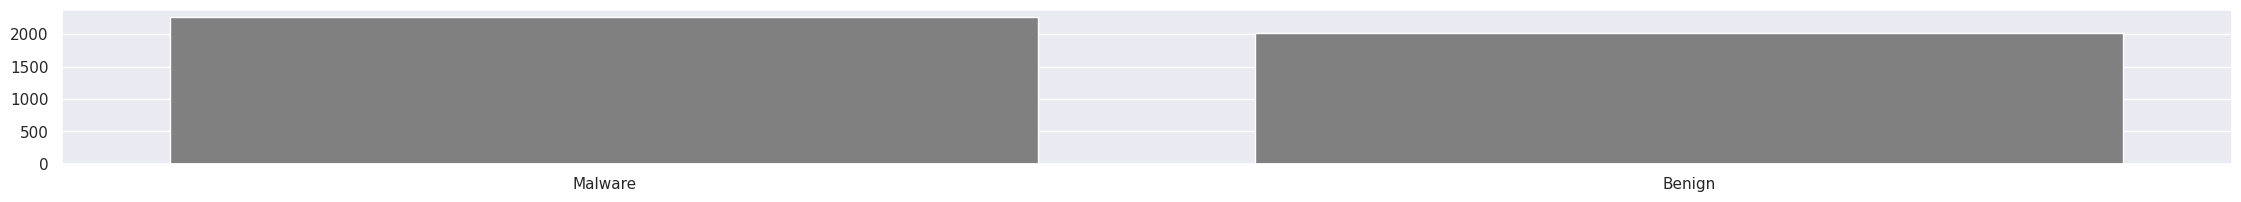

In [552]:
fig = plt.figure(1, figsize=(28,2))
classes_distribution = df['label'].value_counts().to_frame().reset_index().to_numpy()
sns.barplot(x = [classes_distribution[0][0],classes_distribution[1][0]] , y = [classes_distribution[0][1] , classes_distribution[1][1]] , color = "gray")
plt.show()

In [553]:
df.shape

(4282, 26)

As you can see the amount of malware samples and the amount of benign samples quite balanced.

### **Dealing with missing values :**


In [554]:
means = df.isnull().mean()
percentages = means[means > 0].round(4).mul(100).sort_values(ascending=False)
percentages

request.headers.Content-Length    93.02
response.headers.Set-Cookie       93.02
response.headers.Location         90.64
request.headers.Cookie            86.78
dtype: float64

As you can see these columns contain a high percentage of missing values in the data set.

In [555]:
for column in df.columns[df.isna().any()].tolist():
    df[column] = df[column].fillna('None')
    # df.drop(column, axis=1, inplace=True)

In [556]:
print(f'The size of the training set is : {df.shape}')

The size of the training set is : (4282, 26)


In [557]:
df.head(2)

,request.headers.Host,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept,request.headers.Connection,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-User,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,request.body,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,127.0.0.1:5000,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",*/*,keep-alive,de-CH,none,same-origin,?1,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,127.0.0.1:5000,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",*/*,keep-alive,de,none,same-origin,?1,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign


### **Feature Enginering :**

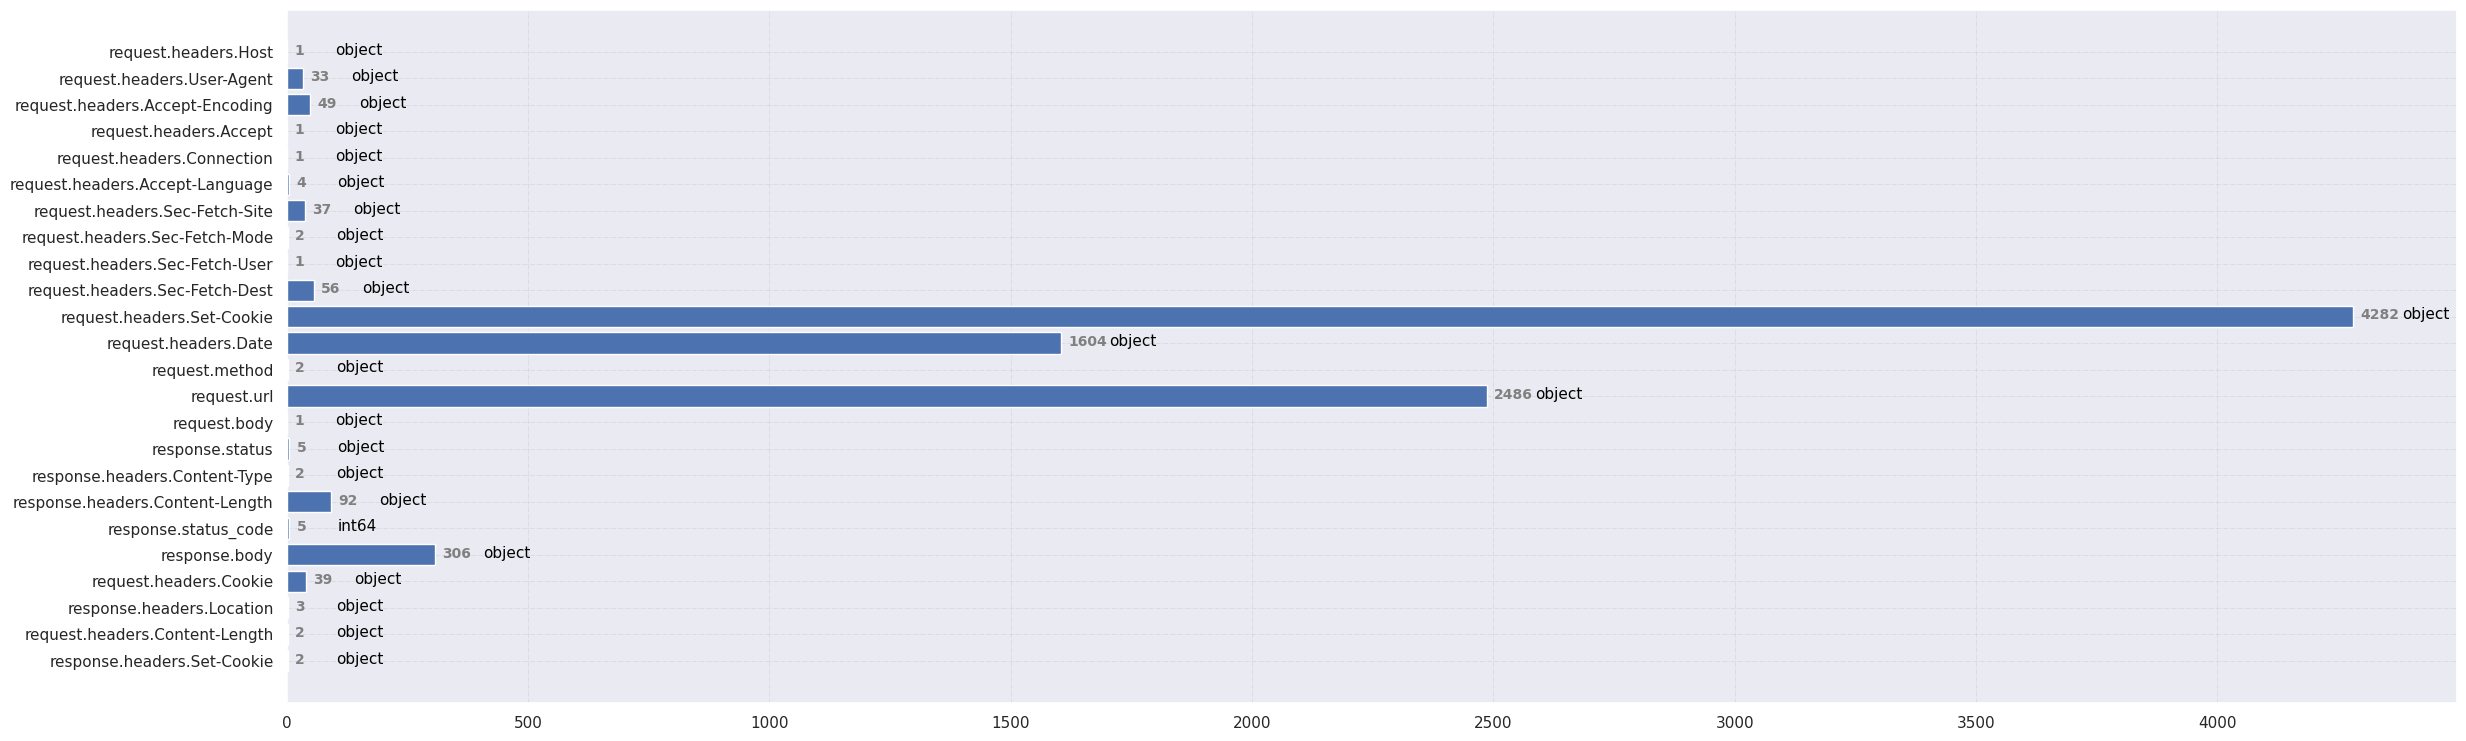

In [ ]:
# Iterate through the data set and check for each column what types it contains and their quantities.
features , unique_values = ([],[])
same_value_features = []
for (col_name,col_value) in df.iteritems():
    if (col_name != "label" and col_name != "attack_type"):
        features.append(col_name)
        unique_values.append(len(np.unique(col_value)))
        if(unique_values[-1] == 1):
          # add the columns that contains one value for each record in the dataset
          same_value_features.append(col_name)

counter = 0
fig, ax = plt.subplots(figsize =(28, 9)) 
# Horizontal Bar Plot
ax.barh(features, unique_values)
# Add x, y gridlines
ax.grid(b = True, color ='grey',linestyle ='-.', linewidth = 0.5,alpha = 0.2)
# Show top values
ax.invert_yaxis()
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width() + 15, i.get_y() + 0.5, str(round((i.get_width()), 2)),fontsize = 10, fontweight ='bold', color ='grey')
    col_name = features[counter]
    plt.text(i.get_width() + 100, i.get_y() + 0.5, df[str(col_name)].dtype ,fontsize = 11, color ='black')
    counter = counter + 1

# Show Plot
plt.show()


As you can see, there are five attributes that contain the same value for all records in the dataset:
1. Host ip from the request header
2. HTTP Accept from the request header
3. Connection type from the request header
4. Sec-Fetch-User fetch metadata from the request header
5. Request body from the request header

It's not useful for building the model because it doesn't provide information that can help distinguish one record from another. In this case, we will remove the features from the dataset.

In [ ]:
dataset = df.drop(same_value_features, axis = 1)
dataset.head(4)

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",de-CH,none,same-origin,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",de,none,same-origin,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",de,none,same-origin,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",de-CH,none,same-origin,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign


There are two columns which describe the same case where an answer is received for a certain request.
I will check if the values are equal in both columns, if so I will leave one column instead of using both.

In [ ]:
dataset['response.status'].unique().tolist()

['200 OK',
 '404 NOT FOUND',
 '401 UNAUTHORIZED',
 '308 PERMANENT REDIRECT',
 '302 FOUND']

In [ ]:
response_check = dataset[['response.status' , 'response.status_code']]
response_check = response_check.replace({'response.status': {'200 OK': 200,'302 FOUND':302,'308 PERMANENT REDIRECT':308,'401 UNAUTHORIZED':401,'404 NOT FOUND': 404}})
print(response_check['response.status'].equals(response_check['response.status_code']))

True


In [ ]:
dataset.head(4)

,request.headers.User-Agent,request.headers.Accept-Encoding,request.headers.Accept-Language,request.headers.Sec-Fetch-Site,request.headers.Sec-Fetch-Mode,request.headers.Sec-Fetch-Dest,request.headers.Set-Cookie,request.headers.Date,request.method,request.url,response.status,response.headers.Content-Type,response.headers.Content-Length,response.status_code,response.body,request.headers.Cookie,response.headers.Location,request.headers.Content-Length,response.headers.Set-Cookie,attack_type,label
0,Mozilla/5.0 (X11; Linux i586; rv:31.0) Gecko/2...,"gzip, deflate, br",de-CH,none,same-origin,document,['ck=o_GpTr9HHJJuQyahzYzRI32s-1_JPvkhLtweRRmjP...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/static/download_txt/../....,200 OK,application/json,72,200,"{""error"": ""File ../../../../../../../../window...",None,None,None,None,Directory Traversal,Malware
1,Mozilla/5.0 (X11; OpenBSD amd64; rv:28.0) Geck...,"gzip, deflate, br",de,none,same-origin,document,['ck=UYrrg74Ph7dWrlCA9rgXy6qtYSwxuCZK_nBsCp-j5...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/categories/check/name/2467,404 NOT FOUND,application/json,41,404,"{""error"": ""Category name not found""}",None,None,None,None,Benign,Benign
2,Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:24....,"gzip, deflate, br",de,none,same-origin,document,['ck=wiMIulyT7VOEQKT-4D5ChZAjxiTdRXAYUaz_OQ3Rc...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/cookielogin,200 OK,text/html; charset=utf-8,105,200,<h1>Logged in as Cedric</h1><form method='POST...,username=gASVyQAAAAAAAACMCGJ1aWx0aW5zlIwEZXZhb...,None,None,None,Cookie Injection,Malware
3,Mozilla/5.0 (Windows NT 6.1; rv:27.3) Gecko/20...,"gzip, deflate, br",de-CH,none,same-origin,document,['ck=pQiHhJSsvZ9vw-yR8NmaTGKzqUBsn583t3Q6zWEoz...,"Mon, 21 Nov 2022 18:12:16 GMT",GET,http://127.0.0.1:5000/states/get/region/6117,404 NOT FOUND,application/json,30,404,"{""error"": ""Not a region""}",None,None,None,None,Benign,Benign


> ### Dealing with categorical features

In [ ]:
# Setting features for further feature extraction by choosing columns
# Some will be "simply" encoded via label encoding and others with HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from collections import Counter
import xgboost as xgb

In [ ]:
# On these headers we will run a "simple" BOW
SIMPLE_HEADERS = ['request.headers.Accept-Encoding',
                'request.method',
                'request.headers.Accept-Language',
                'request.headers.Sec-Fetch-Site',
                'request.headers.Sec-Fetch-Mode',
                'request.headers.Sec-Fetch-Dest',
                ]

# On these headers we will run HashingVectorizer
COMPLEX_HEADERS = ['request.headers.User-Agent',
                    'request.headers.Set-Cookie',
                    'request.headers.Date',
                    'request.url',
                    'response.headers.Content-Type',
                    'response.body',
                    'response.headers.Location',
                    'request.headers.Content-Length',
                    'request.headers.Cookie',
                    'response.headers.Set-Cookie'
                    ]

COLUMNS_TO_REMOVE = [
                    'response.status',
                    'request.headers.Date']

# This is our main preprocessing function that will iterate over all of the chosen 
# columns and run some feature extraction models
def vectorize_df(df):
    le = LabelEncoder()
    h_vec = HashingVectorizer(n_features=4)

    # Run LabelEncoder on the chosen features
    for column in SIMPLE_HEADERS: 
        df[column] = le.fit_transform(df[column])
    
    # Run HashingVectorizer on the chosen features
    for column in COMPLEX_HEADERS: 
        newHVec = h_vec.fit_transform(df[column])
        df[column] = newHVec.todense()

    # Remove some columns that may be needed.. (Or not, you decide)
    for column in COLUMNS_TO_REMOVE: 
        df.drop(column, axis=1, inplace=True)
    return df

df = vectorize_df(dataset)

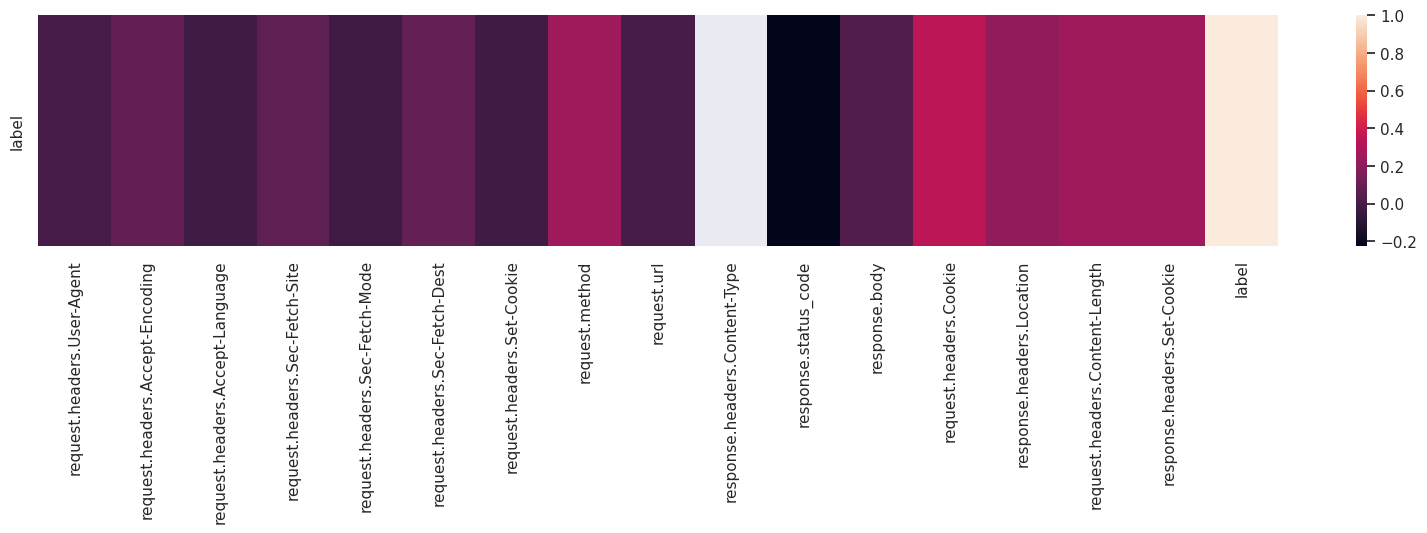

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20,3
dataset_correlation = df.replace({'label': {'Malware': 1,'Benign':0}})
sns.heatmap(dataset_correlation.corr().tail(1))

In [ ]:
df.shape

(4282, 19)

In [ ]:
# Memory check (For large datasets sometimes the dataframe will exceed the computers resources)
df.info(memory_usage="deep")

In [ ]:
# Choose the right features
# In our example code we choose all the columns as our feature this can be the right or wrong way to approach the model, you choose.

features_list = df.columns.to_list()
features_list.remove('label')
features_list.remove('attack_type')
print(features_list)

# Recheck all datatype before training to see we don't have any objects in our features
# In this example our model must get features containing only numbers so we recheck to see if we missed anything during preprocessing
df.dtypes

## Train test split

In [ ]:
# Data train and test split preparations. Here we will insert our feature list and label list.
# Afterwards the data will be trained and fitted on the amazing XGBoost model
# X_Train and y_Train will be used for training
# X_test and y_test.T will be used for over fitting checking and overall score testing

# We convert the feature list to a numpy array, this is required for the model fitting
X = df[features_list].to_numpy()

# This column is the desired prediction we will train our model on
y = np.stack(df[test_type])

# We split the dataset to train and test according to the required ration
# Do not change the test_size -> you can change anything else
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# We print the resulted datasets and count the difference 
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
counter = Counter(y)
counter

(3425, 17) (3425,)
(857, 17) (857,)


Counter({'Malware': 2264, 'Benign': 2018})

## Model choosing and fitting

In [ ]:
# We choose our model of choice and set it's hyper parameters you can change anything
clf = xgb.XGBClassifier(objective="binary:logistic", random_state=45)
clf.fit(X_train, y_train)

# Check data balance and variety
print(sorted(Counter(y_train).items()))

[('Benign', 1614), ('Malware', 1811)]


## Result printout

              precision    recall  f1-score   support

      Benign    0.92199   0.96535   0.94317       404
     Malware    0.96774   0.92715   0.94701       453

    accuracy                        0.94516       857
   macro avg    0.94486   0.94625   0.94509       857
weighted avg    0.94617   0.94516   0.94520       857



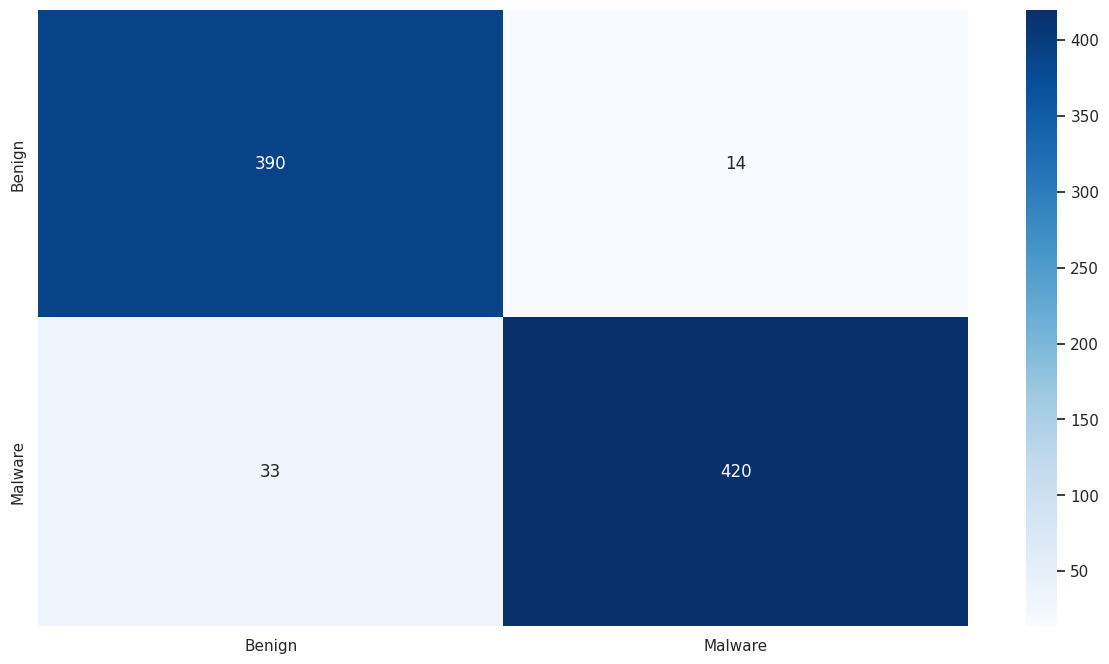

In [ ]:
# We print our results
sns.set(rc={'figure.figsize':(15,8)})
predictions = clf.predict(X_test)
true_labels = y_test
cf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

# The heatmap is cool but this is the most important result
print(clf_report)

# Test

In [ ]:
# Now it's your turn, use the model you have just created :)

# Read the valuation json, preprocess it and run your model 
with open("/content/drive/MyDrive/CiscoChallenge/Data/dataset_1_val.json") as file:
    raw_ds = json.load(file)
test_df = pd.json_normalize(raw_ds, max_level=2)

# Preprocess the validation dataset, remember that here you don't have the labels
test_df.drop(same_value_features ,axis=1, inplace=True )

for column in test_df.columns[test_df.isna().any()].tolist():
    test_df[column] = test_df[column].fillna('None')

test_df = vectorize_df(test_df)
# Predict with your model
X = test_df[features_list].to_numpy()
predictions = clf.predict(X)

# Save your predictions

In [ ]:
# Save your preditions
enc = LabelEncoder()
np.savetxt(f'/content/drive/MyDrive/CiscoChallenge/dataset_1_{test_type}_result.txt', enc.fit_transform(predictions), fmt='%2d')